In [ ]:
import torch
print(torch.__version__)

2.7.0+cu126


In [ ]:
!pip install torch==2.6.0 --index-url https://download.pytorch.org/whl/cu124
!pip install -r requirements.txt

Looking in indexes: https://download.pytorch.org/whl/cu124
  Using cached https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp39-cp39-linux_x86_64.whl (768.4 MB)
  Using cached https://download.pytorch.org/whl/cu124/nvidia_nvtx_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl (99 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Using cached https://download.pytorch.org/whl/cu124/nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl (363.4 MB)
  Using cached https://download.pytorch.org/whl/cu124/nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl (207.5 MB)
  Using cached https://download.pytorch.org/whl/cu124/nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
  Using cached https://download.pytorch.org/whl/cu124/nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl (24.6 MB)
  Using cached https://download.pytorch.org/whl/nvidia_nccl_cu12-2.21.5-py3-none-manylinux2014_x86_64.w

In [ ]:
import transformers
print("Transformers version:", transformers.__version__)

Transformers version: 4.51.3


In [ ]:
import peft
print("PEFT version:", peft.__version__)

PEFT version: 0.15.2


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import get_peft_model, LoraConfig, TaskType

model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    task_type=TaskType.SEQ_CLS,
    lora_dropout=0.05,
    bias="none"
)

model = get_peft_model(model, peft_config)
print(model)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): Mo

In [ ]:
pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#roberta_train_and_save.py
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import StratifiedKFold
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm
import pickle

os.makedirs("models/roberta", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("preds", exist_ok=True)

# Load Data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

train_texts = train['text'].values
train_labels = train['target'].values
test_texts = test['text'].values

tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

# Dataset
class TweetDataset(Dataset):
    def __init__(self, texts, tokenizer, labels=None):
        self.texts = texts
        self.tokenizer = tokenizer
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# LoRA config
def add_lora(model):
    config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            inference_mode=False,
            r=8,
            lora_alpha=32,
            lora_dropout=0.1,
            target_modules=["query", "value"]
    )
    return get_peft_model(model, config)

# Early Stopper
class EarlyStopper:
    def __init__(self, patience=2, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.best_model = None

    def early_stop(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_texts, train_labels)):
    print(f"\n=== Fold {fold} ===")

    train_texts_fold = [train_texts[i] for i in train_idx]
    train_labels_fold = [train_labels[i] for i in train_idx]
    val_texts_fold = [train_texts[i] for i in val_idx]
    val_labels_fold = [train_labels[i] for i in val_idx]

    train_ds = TweetDataset(train_texts_fold, tokenizer, train_labels_fold)
    val_ds = TweetDataset(val_texts_fold, tokenizer, val_labels_fold)
    test_ds = TweetDataset(test_texts, tokenizer)

    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=16)
    test_loader = DataLoader(test_ds, batch_size=16)

    # Model
    model = RobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=2)
    model = add_lora(model).to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * 3
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0.1 * total_steps, num_training_steps=total_steps)
    stopper = EarlyStopper()

    log = {'train_loss': [], 'val_loss': []}

    for epoch in range(5):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)

        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                val_losses.append(outputs.loss.item())

        avg_val_loss = np.mean(val_losses)

        log['train_loss'].append(avg_train_loss)
        log['val_loss'].append(avg_val_loss)
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if stopper.early_stop(avg_val_loss, model):
            print("Early stopping.")
            model.load_state_dict(stopper.best_model)
            break

    # Save model
    torch.save(model.state_dict(), f"models/roberta/fold{fold}.pt")

    # Save log
    with open(f"logs/roberta_fold{fold}_log.pkl", "wb") as f:
        pickle.dump(log, f)

    # Inference
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(**batch).logits
            preds.append(torch.softmax(logits, dim=1).cpu().numpy())
    np.save(f"preds/roberta_fold{fold}_probs.npy", np.vstack(preds))

print("\n✅ Training and saving completed for RoBERTa")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]


=== Fold 0 ===


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 762/762 [03:23<00:00,  3.74it/s]


Train Loss: 0.5436 | Val Loss: 0.4396


Epoch 2: 100%|██████████| 762/762 [03:22<00:00,  3.77it/s]


Train Loss: 0.4029 | Val Loss: 0.4147


Epoch 3: 100%|██████████| 762/762 [03:21<00:00,  3.77it/s]


Train Loss: 0.3854 | Val Loss: 0.3960


Epoch 4: 100%|██████████| 762/762 [03:21<00:00,  3.77it/s]


Train Loss: 0.3760 | Val Loss: 0.3960


Epoch 5: 100%|██████████| 762/762 [03:21<00:00,  3.77it/s]


Train Loss: 0.3776 | Val Loss: 0.3960
Early stopping.

=== Fold 1 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 762/762 [03:22<00:00,  3.77it/s]


Train Loss: 0.5378 | Val Loss: 0.3886


Epoch 2: 100%|██████████| 762/762 [03:21<00:00,  3.77it/s]


Train Loss: 0.4012 | Val Loss: 0.3749


Epoch 3: 100%|██████████| 762/762 [03:21<00:00,  3.77it/s]


Train Loss: 0.3748 | Val Loss: 0.3665


Epoch 4: 100%|██████████| 762/762 [03:21<00:00,  3.77it/s]


Train Loss: 0.3733 | Val Loss: 0.3665


Epoch 5: 100%|██████████| 762/762 [03:21<00:00,  3.77it/s]


Train Loss: 0.3735 | Val Loss: 0.3665
Early stopping.

=== Fold 2 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 762/762 [03:22<00:00,  3.77it/s]


Train Loss: 0.5531 | Val Loss: 0.4215


Epoch 2: 100%|██████████| 762/762 [03:21<00:00,  3.77it/s]


Train Loss: 0.4014 | Val Loss: 0.4009


Epoch 3: 100%|██████████| 762/762 [03:22<00:00,  3.77it/s]


Train Loss: 0.3805 | Val Loss: 0.3967


Epoch 4: 100%|██████████| 762/762 [03:21<00:00,  3.77it/s]


Train Loss: 0.3778 | Val Loss: 0.3967


Epoch 5: 100%|██████████| 762/762 [03:22<00:00,  3.77it/s]


Train Loss: 0.3724 | Val Loss: 0.3967
Early stopping.

=== Fold 3 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 762/762 [03:22<00:00,  3.77it/s]


Train Loss: 0.5494 | Val Loss: 0.4347


Epoch 2: 100%|██████████| 762/762 [03:22<00:00,  3.77it/s]


Train Loss: 0.4028 | Val Loss: 0.3905


Epoch 3: 100%|██████████| 762/762 [03:22<00:00,  3.77it/s]


Train Loss: 0.3824 | Val Loss: 0.3879


Epoch 4: 100%|██████████| 762/762 [03:22<00:00,  3.77it/s]


Train Loss: 0.3728 | Val Loss: 0.3879


Epoch 5: 100%|██████████| 762/762 [03:22<00:00,  3.77it/s]


Train Loss: 0.3701 | Val Loss: 0.3879
Early stopping.

=== Fold 4 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 762/762 [03:22<00:00,  3.77it/s]


Train Loss: 0.5737 | Val Loss: 0.4343


Epoch 2: 100%|██████████| 762/762 [03:22<00:00,  3.77it/s]


Train Loss: 0.3955 | Val Loss: 0.4037


Epoch 3: 100%|██████████| 762/762 [03:22<00:00,  3.77it/s]


Train Loss: 0.3819 | Val Loss: 0.4032


Epoch 4: 100%|██████████| 762/762 [03:22<00:00,  3.77it/s]


Train Loss: 0.3787 | Val Loss: 0.4032


Epoch 5: 100%|██████████| 762/762 [03:21<00:00,  3.77it/s]


Train Loss: 0.3732 | Val Loss: 0.4032
Early stopping.

✅ Training and saving completed for RoBERTa


In [ ]:
#deberta_train_and_save.py
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import StratifiedKFold
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm
import pickle

os.makedirs("models/deberta", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("preds", exist_ok=True)

# Load Data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

train_texts = train['text'].values
train_labels = train['target'].values
test_texts = test['text'].values

tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-base")

# Dataset
class TweetDataset(Dataset):
    def __init__(self, texts, tokenizer, labels=None):
        self.texts = texts
        self.tokenizer = tokenizer
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# LoRA config
def add_lora(model):
    config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            inference_mode=False,
            r=8,
            lora_alpha=32,
            lora_dropout=0.1,
            target_modules=["query_proj", "value_proj"]
    )
    return get_peft_model(model, config)

# Early Stopper
class EarlyStopper:
    def __init__(self, patience=2, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.best_model = None

    def early_stop(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_texts, train_labels)):
    print(f"\n=== Fold {fold} ===")

    train_texts_fold = [train_texts[i] for i in train_idx]
    train_labels_fold = [train_labels[i] for i in train_idx]
    val_texts_fold = [train_texts[i] for i in val_idx]
    val_labels_fold = [train_labels[i] for i in val_idx]

    train_ds = TweetDataset(train_texts_fold, tokenizer, train_labels_fold)
    val_ds = TweetDataset(val_texts_fold, tokenizer, val_labels_fold)
    test_ds = TweetDataset(test_texts, tokenizer)

    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=16)
    test_loader = DataLoader(test_ds, batch_size=16)

    # Model
    model = DebertaV2ForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=2)

    model = add_lora(model).to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * 3
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0.1 * total_steps, num_training_steps=total_steps)
    stopper = EarlyStopper()

    log = {'train_loss': [], 'val_loss': []}

    for epoch in range(5):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)

        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                val_losses.append(outputs.loss.item())

        avg_val_loss = np.mean(val_losses)

        log['train_loss'].append(avg_train_loss)
        log['val_loss'].append(avg_val_loss)
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if stopper.early_stop(avg_val_loss, model):
            print("Early stopping.")
            model.load_state_dict(stopper.best_model)
            break

    # Save model
    torch.save(model.state_dict(), f"models/deberta/fold{fold}.pt")

    # Save log
    with open(f"logs/deberta_fold{fold}_log.pkl", "wb") as f:
        pickle.dump(log, f)

    # Inference
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(**batch).logits
            preds.append(torch.softmax(logits, dim=1).cpu().numpy())
    np.save(f"preds/deberta_fold{fold}_probs.npy", np.vstack(preds))

print("\n✅ Training and saving completed for DeBERTa")


=== Fold 0 ===


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 762/762 [01:27<00:00,  8.73it/s]


Train Loss: 0.6663 | Val Loss: 0.5710


Epoch 2: 100%|██████████| 762/762 [01:26<00:00,  8.81it/s]


Train Loss: 0.5059 | Val Loss: 0.4544


Epoch 3: 100%|██████████| 762/762 [01:26<00:00,  8.81it/s]


Train Loss: 0.4629 | Val Loss: 0.4417


Epoch 4: 100%|██████████| 762/762 [01:26<00:00,  8.82it/s]


Train Loss: 0.4542 | Val Loss: 0.4417


Epoch 5: 100%|██████████| 762/762 [01:26<00:00,  8.82it/s]


Train Loss: 0.4572 | Val Loss: 0.4417
Early stopping.

=== Fold 1 ===


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 762/762 [01:26<00:00,  8.82it/s]


Train Loss: 0.6646 | Val Loss: 0.5665


Epoch 2: 100%|██████████| 762/762 [01:26<00:00,  8.82it/s]


Train Loss: 0.4669 | Val Loss: 0.4242


Epoch 3: 100%|██████████| 762/762 [01:26<00:00,  8.79it/s]


Train Loss: 0.4187 | Val Loss: 0.4117


Epoch 4: 100%|██████████| 762/762 [01:26<00:00,  8.80it/s]


Train Loss: 0.4212 | Val Loss: 0.4117


Epoch 5: 100%|██████████| 762/762 [01:26<00:00,  8.81it/s]


Train Loss: 0.4194 | Val Loss: 0.4117
Early stopping.

=== Fold 2 ===


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 762/762 [01:26<00:00,  8.83it/s]


Train Loss: 0.6685 | Val Loss: 0.5911


Epoch 2: 100%|██████████| 762/762 [01:26<00:00,  8.83it/s]


Train Loss: 0.5082 | Val Loss: 0.4717


Epoch 3: 100%|██████████| 762/762 [01:26<00:00,  8.82it/s]


Train Loss: 0.4544 | Val Loss: 0.4574


Epoch 4: 100%|██████████| 762/762 [01:26<00:00,  8.79it/s]


Train Loss: 0.4515 | Val Loss: 0.4574


Epoch 5: 100%|██████████| 762/762 [01:26<00:00,  8.81it/s]


Train Loss: 0.4486 | Val Loss: 0.4574
Early stopping.

=== Fold 3 ===


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 762/762 [01:26<00:00,  8.84it/s]


Train Loss: 0.6883 | Val Loss: 0.6159


Epoch 2: 100%|██████████| 762/762 [01:26<00:00,  8.80it/s]


Train Loss: 0.5414 | Val Loss: 0.4925


Epoch 3: 100%|██████████| 762/762 [01:26<00:00,  8.82it/s]


Train Loss: 0.4805 | Val Loss: 0.4731


Epoch 4: 100%|██████████| 762/762 [01:26<00:00,  8.82it/s]


Train Loss: 0.4753 | Val Loss: 0.4731


Epoch 5: 100%|██████████| 762/762 [01:26<00:00,  8.81it/s]


Train Loss: 0.4711 | Val Loss: 0.4731
Early stopping.

=== Fold 4 ===


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 762/762 [01:26<00:00,  8.80it/s]


Train Loss: 0.6760 | Val Loss: 0.5896


Epoch 2: 100%|██████████| 762/762 [01:26<00:00,  8.83it/s]


Train Loss: 0.4509 | Val Loss: 0.4170


Epoch 3: 100%|██████████| 762/762 [01:26<00:00,  8.83it/s]


Train Loss: 0.4102 | Val Loss: 0.4171


Epoch 4: 100%|██████████| 762/762 [01:26<00:00,  8.81it/s]


Train Loss: 0.4043 | Val Loss: 0.4171
Early stopping.

✅ Training and saving completed for RoBERTa


In [ ]:
# inference_vote.py
import numpy as np
import pandas as pd
import glob
from collections import Counter

submission = pd.read_csv("sample_submission.csv")

# 分類每折的模型
pred_files = sorted(glob.glob("preds/*_probs.npy"))  # e.g., ['deberta_fold0_probs.npy', 'roberta_fold0_probs.npy', ...]

# 確認每折都有兩個模型
fold_groups = {}
for f in pred_files:
    fold_num = int(f.split("fold")[1].split("_")[0])
    fold_groups.setdefault(fold_num, []).append(f)

# 確保每折有兩個模型
for fold, files in fold_groups.items():
    assert len(files) == 2, f"Fold {fold} 沒有兩個模型！"

# 每折投票後的結果
fold_preds = []

for fold, files in sorted(fold_groups.items()):
    print(f"處理 Fold {fold}: {files}")
    # 讀取兩個模型的預測
    probs1 = np.load(files[0])
    probs2 = np.load(files[1])

    # 各自取 argmax
    argmax1 = np.argmax(probs1, axis=1)
    argmax2 = np.argmax(probs2, axis=1)

    # 兩者投票 (選出 softmax 最大值那個模型的類別)
    # 也可以直接選兩者中 softmax 最大的類別
    max_probs1 = np.max(probs1, axis=1)
    max_probs2 = np.max(probs2, axis=1)
    final_vote = np.where(max_probs1 >= max_probs2, argmax1, argmax2)

    fold_preds.append(final_vote)

# 將每折的結果加總後再取平均
fold_preds = np.stack(fold_preds)  # shape: (n_folds, n_samples)
print("每折 shape:", fold_preds.shape)

# 多數決
final_preds = []
for i in range(fold_preds.shape[1]):  # 每個樣本
    sample_votes = fold_preds[:, i]
    vote = Counter(sample_votes).most_common(1)[0][0]
    final_preds.append(vote)

submission['target'] = final_preds
submission.to_csv("submission_vote.csv", index=False)
print("✅ submission_vote.csv saved.")


處理 Fold 0: ['preds/deberta_fold0_probs.npy', 'preds/roberta_fold0_probs.npy']
處理 Fold 1: ['preds/deberta_fold1_probs.npy', 'preds/roberta_fold1_probs.npy']
處理 Fold 2: ['preds/deberta_fold2_probs.npy', 'preds/roberta_fold2_probs.npy']
處理 Fold 3: ['preds/deberta_fold3_probs.npy', 'preds/roberta_fold3_probs.npy']
處理 Fold 4: ['preds/deberta_fold4_probs.npy', 'preds/roberta_fold4_probs.npy']
每折 shape: (5, 3263)
✅ submission_vote.csv saved.


In [ ]:
import numpy as np
import pandas as pd

# 載入 sample submission
submission = pd.read_csv("sample_submission.csv")

# 權重調整（例如 0.6 RoBERTa、0.4 DeBERTa）
roberta_weight = 0.3
deberta_weight = 0.7

# 初始累加
test_preds = np.zeros((len(submission), 2))

# 加總所有 fold 的加權預測
for fold in range(5):
    roberta_probs = np.load(f"preds/roberta_fold{fold}_probs.npy")
    deberta_probs = np.load(f"preds/deberta_fold{fold}_probs.npy")

    fold_preds = roberta_weight * roberta_probs + deberta_weight * deberta_probs
    test_preds += fold_preds
    #test_preds += fold_preds / 5  # 平均
test_preds = test_preds / 5  # 平均
# 最終 argmax 預測
final_preds = np.argmax(test_preds, axis=1)
submission['target'] = final_preds

# 儲存檔案
output_name = f"submission_{int(roberta_weight*10)}_{int(deberta_weight*10)}.csv"
submission.to_csv(output_name, index=False)
print(f"✅ 預測完成並儲存為：{output_name}")


✅ 預測完成並儲存為：submission_3_7.csv


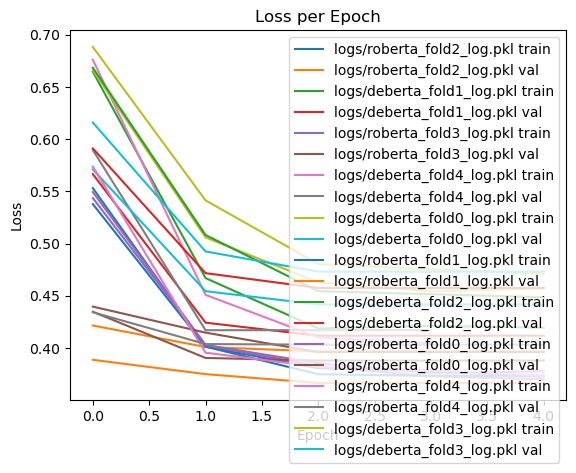

preds/deberta_fold4_probs.npy ROC-AUC: 0.5326


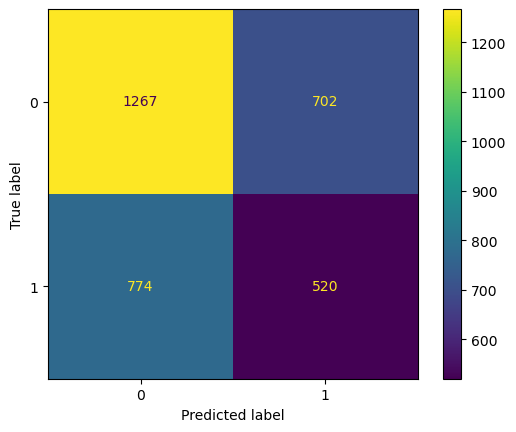

preds/deberta_fold0_probs.npy ROC-AUC: 0.5371


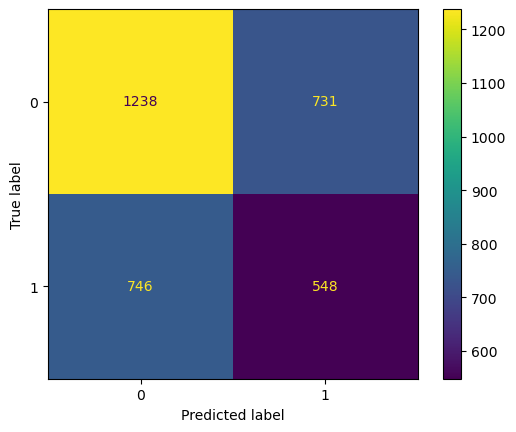

preds/deberta_fold1_probs.npy ROC-AUC: 0.5394


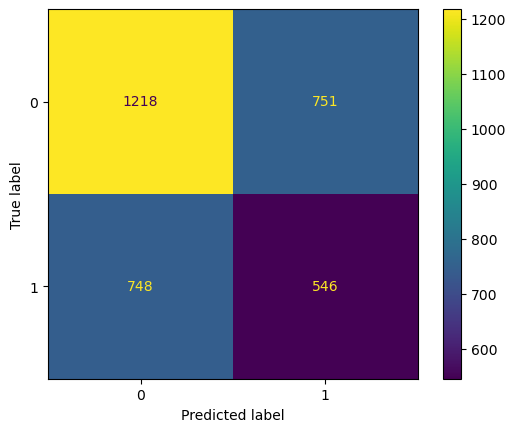

preds/deberta_fold2_probs.npy ROC-AUC: 0.5403


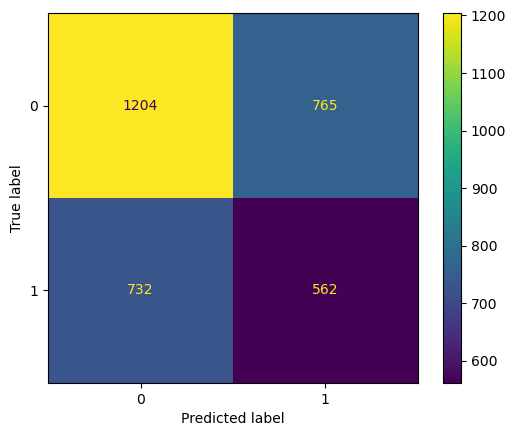

preds/deberta_fold3_probs.npy ROC-AUC: 0.5426


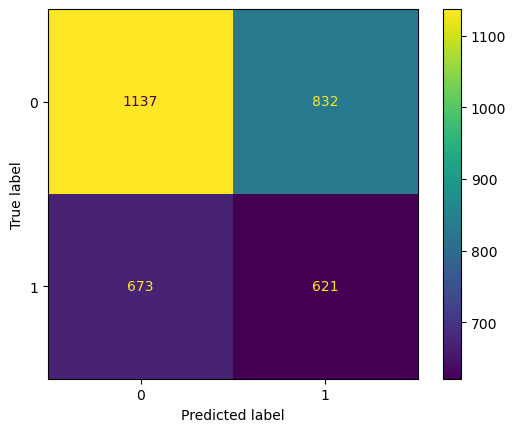

preds/roberta_fold0_probs.npy ROC-AUC: 0.5385


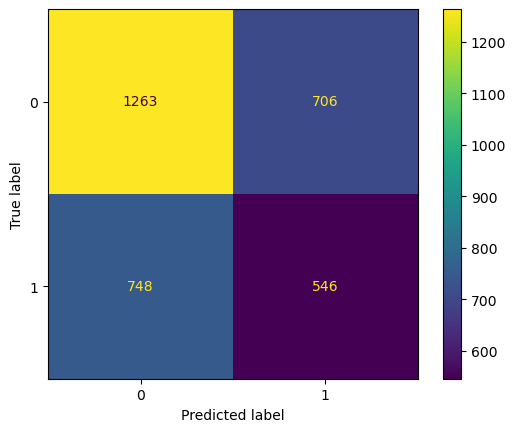

preds/roberta_fold1_probs.npy ROC-AUC: 0.5320


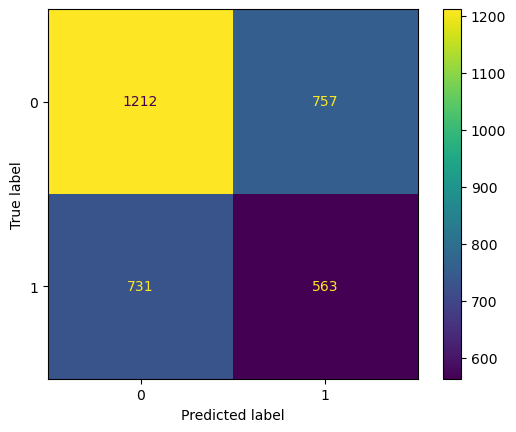

preds/roberta_fold2_probs.npy ROC-AUC: 0.5393


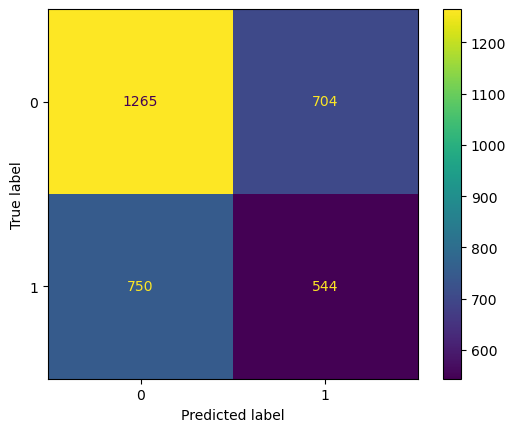

preds/roberta_fold3_probs.npy ROC-AUC: 0.5383


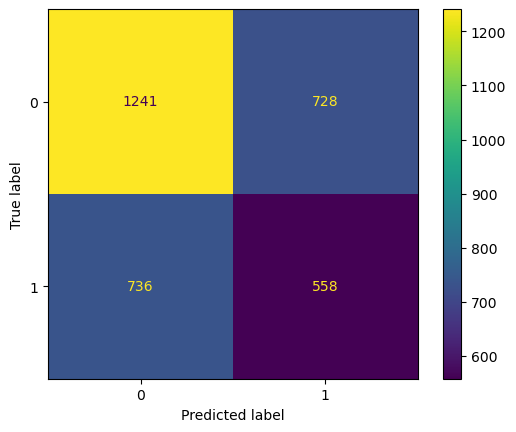

preds/roberta_fold4_probs.npy ROC-AUC: 0.5344


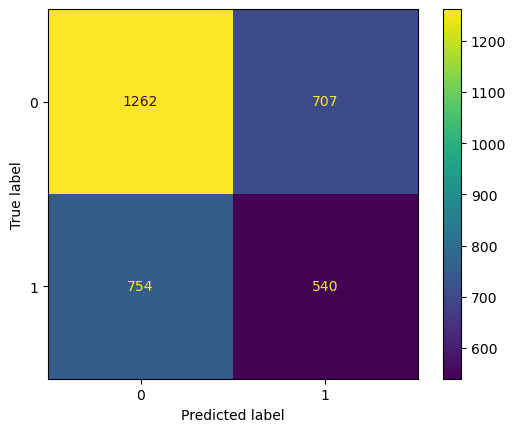

In [ ]:
# plot.py
import pickle
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Plot Loss & F1
for log_file in glob.glob("logs/*.pkl"):
    with open(log_file, "rb") as f:
        log = pickle.load(f)
    plt.plot(log['train_loss'], label=f"{log_file} train")
    plt.plot(log['val_loss'], label=f"{log_file} val")
plt.legend()
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# ROC-AUC & Confusion Matrix (示範)
probs_files = glob.glob("preds/*_probs.npy")
for f in probs_files:
    probs = np.load(f)
    y_pred = np.argmax(probs, axis=1)
    y_true = pd.read_csv("train.csv")['target'].values  # 假設全部同標籤（真實情況應該要有 validation label）
    auc = roc_auc_score(y_true[:len(y_pred)], probs[:, 1])
    print(f"{f} ROC-AUC: {auc:.4f}")

    cm = confusion_matrix(y_true[:len(y_pred)], y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()
